# Final Project Submission

* Student name: Michael Mathews Jr
* Student pace: part time
* Scheduled project review date/time: June 9, 2020. 8:30am PST.
* Instructor name: Eli Thomas
* Blog post URL: https://medium.com/@M_84821/predicting-customer-churn-telecommunications-e76010fc37c0

# Import libraries & data

In [177]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
import xgboost as xgb

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('datasets_2667_4430_bigml_59c28831336c6604c800002a.csv')

In [3]:
pd.set_option('display.max_columns', None)

# Preprocessing the data

In [4]:
# Creating new feature for 3 digit phone number.
df['3digit_pn'] = df['phone number'].map(lambda x: x.split('-')[0]).astype(int)

In [5]:
df.drop('phone number', axis=1, inplace=True)

In [6]:
# Creating target variable.
df['churn'] = df['churn'].map(lambda x: 0 if x == False else 1)

# Splitting data into train/test sets & encoding categorical features

In [7]:
X = df.drop(['churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=25)

In [8]:
# transforming 2 features by one hot encoding.
ohe = OneHotEncoder(cols=['international plan', 'voice mail plan'])

In [9]:
data_train = ohe.fit_transform(X_train)
data_test = ohe.fit_transform(X_test)

In [10]:
# Transforming the remaining catergorical features with a target encoder.
enc = TargetEncoder()
enc_data_train = enc.fit_transform(data_train, y_train)
enc_data_test = enc.transform(data_test)

# Random Forest Classifier

In [11]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(enc_data_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [12]:
y_pred = rfc.predict(enc_data_test)

In [13]:
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
Actual,,,
0,716,4,720
1,55,59,114
All,771,63,834


In [14]:
# Evaluating the Null Score, comparing/contrasting against the classification report.
ns = 1 - y_test.mean()
print(f'Null score: {ns}')
print(classification_report(y_test, y_pred))

Null score: 0.8633093525179856
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       720
           1       0.94      0.52      0.67       114

    accuracy                           0.93       834
   macro avg       0.93      0.76      0.81       834
weighted avg       0.93      0.93      0.92       834



### Precision-Recall Curve (RFC)

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

Random Forest Classifier: f1=0.667 auc=0.808


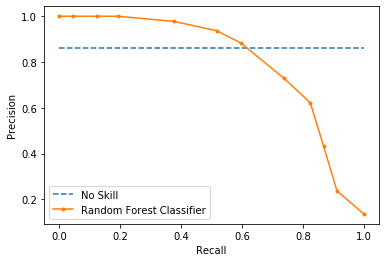

In [189]:
rfc_probs = rfc.predict_proba(enc_data_test)
# keep probabilities for the positive outcome only
rfc_probs= rfc_probs[:, 1]
# predict class values
yhat = rfc.predict(enc_data_test)
rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, rfc_probs)
rfc_f1, rfc_auc = f1_score(y_test, y_pred), auc(rfc_recall, rfc_precision)
# summarize scores
print('Random Forest Classifier: f1=%.3f auc=%.3f' % (rfc_f1, rfc_auc))
# plot the precision-recall curves
no_skill = 1 - y_test.mean()
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rfc_recall, rfc_precision, marker='.', label='Random Forest Classifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

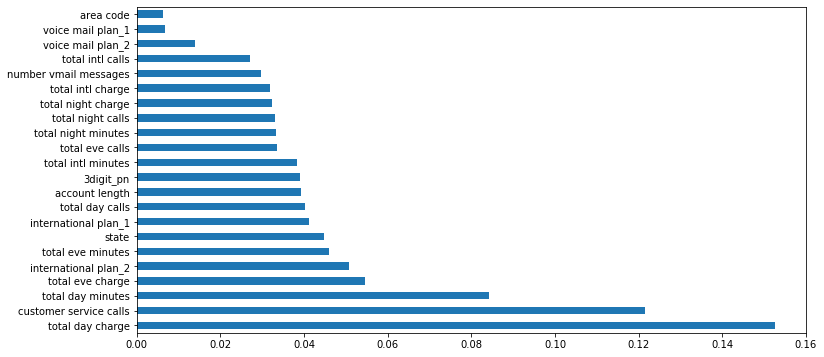

In [17]:
# Feature importance
feat_importances = pd.Series(rfc.feature_importances_, index=enc_data_train.columns)
feat_importances.nlargest(28).plot(kind='barh', figsize=(12,6))
plt.show()

# XGBoost

In [18]:
xgb = xgb.XGBClassifier()
xgb.fit(enc_data_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
y_pred_xgb = xgb.predict(enc_data_test)

In [40]:
y_pred_xgb[629]

0

In [20]:
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
Actual,,,
0,717,3,720
1,31,83,114
All,748,86,834


In [21]:
ns = 1 - y_test.mean()
print(f'Null score: {ns}')
print(classification_report(y_test, y_pred_xgb))

Null score: 0.8633093525179856
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       720
           1       0.97      0.73      0.83       114

    accuracy                           0.96       834
   macro avg       0.96      0.86      0.90       834
weighted avg       0.96      0.96      0.96       834



### Creating a customer contact priority list

In [22]:
probs_y = xgb.predict_proba(enc_data_test)

In [23]:
# Creating a list of probabilities
prob_list = pd.DataFrame(probs_y)

In [96]:
pred = pd.merge(df, prob_list, left_index=True, right_index=True)

In [103]:
predval = pd.DataFrame(y_pred_xgb)

In [104]:
predval = predval.rename(columns={0: 'prediction'})

In [106]:
p_list = pd.merge(pred, predval, left_index=True, right_index=True)

In [113]:
targ = df['churn']
p_list = pd.merge(p_list, targ, left_index=True, right_index=True)

In [114]:
p_list0 = p_list[['3digit_pn', 0, 1, 'prediction', 'churn']]

In [135]:
p_list0 = p_list0.sort_values(by=1, ascending=False)

In [188]:
p_list0.head(15)

,3digit_pn,0,1,prediction,churn
552,419,0.006184,0.993816,1,1
96,370,0.012938,0.987062,1,0
712,340,0.013105,0.986895,1,0
355,371,0.024280,0.975720,1,0
333,365,0.024421,0.975579,1,0
626,348,0.032545,0.967455,1,1
291,335,0.035246,0.964754,1,0
393,352,0.035459,0.964541,1,0
803,371,0.036098,0.963902,1,0
560,342,0.038384,0.961616,1,0


### Precision-Recall Curve (XGB)

XGBoost: f1=0.830 auc=0.872


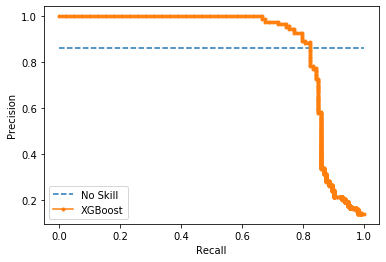

In [118]:
xgb_probs = xgb.predict_proba(enc_data_test)
# keep probabilities for the positive outcome only
xgb_probs= xgb_probs[:, 1]
# predict class values
yhat = xgb.predict(enc_data_test)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_f1, xgb_auc = f1_score(y_test, y_pred_xgb), auc(xgb_recall, xgb_precision)
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
no_skill = 1-y_test.mean()
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGBoost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# Grid search with XGBoost

In [119]:
from sklearn.model_selection import GridSearchCV

In [186]:
param_grid = {
    "learning_rate": [0.1, 0.2],
    'max_depth': [5, 6, 7],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'n_estimators': [75, 80, 85],
    #'class_weight': [{0:0.8, 1:0.2, 0:0.85, 1:0.15, 0:0.9, 1:0.1}]    
}

In [187]:
clf = xgb.XGBClassifier(class_weight='balanced')

grid_clf = GridSearchCV(clf, param_grid, scoring='recall', cv=2, n_jobs=1)
grid_clf.fit(enc_data_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(enc_data_train)
val_preds = grid_clf.predict(enc_data_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
print(classification_report(y_test, val_preds))
print('-------------------------------------')
print('Confusion Matrix')
print(confusion_matrix(y_test, val_preds))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 7
min_child_weight: 2
n_estimators: 75
subsample: 0.9

Training Accuracy: 98.44%
Validation accuracy: 95.92%
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       720
           1       0.99      0.71      0.83       114

    accuracy                           0.96       834
   macro avg       0.97      0.85      0.90       834
weighted avg       0.96      0.96      0.96       834

-------------------------------------
Confusion Matrix
[[719   1]
 [ 33  81]]


# Logistic Regression

In [169]:
lr = LogisticRegression(random_state=0, class_weight={1:6})

In [171]:
lr.fit(enc_data_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={1: 6}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [172]:
y_pred_lr = lr.predict(enc_data_test)

In [173]:
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred_lr, rownames=['Actual'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
Actual,,,
0,549,171,720
1,28,86,114
All,577,257,834


In [174]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       720
           1       0.33      0.75      0.46       114

    accuracy                           0.76       834
   macro avg       0.64      0.76      0.66       834
weighted avg       0.87      0.76      0.79       834



# MLP

In [190]:
from sklearn.neural_network import MLPClassifier

In [191]:
mlp = MLPClassifier()

In [192]:
mlp.fit(enc_data_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [193]:
y_pred_mlp = mlp.predict(enc_data_test)

In [194]:
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       720
           1       0.82      0.32      0.46       114

    accuracy                           0.90       834
   macro avg       0.86      0.65      0.70       834
weighted avg       0.89      0.90      0.88       834



In [195]:
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred_mlp, rownames=['Actual'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
Actual,,,
0,712,8,720
1,78,36,114
All,790,44,834


## Conclusion:
 * XGBoost with grid search provided the most accurate results.
 * "total day charge" and "customer service calls" were the most important features in the dataset, they offered the most information.